In [2]:
# importing libraries
import pandas as pd
import re
import nltk
import numpy as np
import joblib
import string
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import warnings
from multiprocessing import Pool, cpu_count
import os
import psutil
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler

In [3]:
# Suppress BeautifulSoup warnings
warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)

In [4]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
# Load dataset
df = pd.read_csv("/content/Reviews.csv", on_bad_lines='skip')
df = df[['Score', 'Text']].dropna()

In [7]:
# Precompile regex for performance
html_cleaner = re.compile(r'<.*?>')
special_char_cleaner = re.compile(r'[^a-zA-Z0-9\s]')
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')  # Tokenizes words of length 3+
lemmatizer = WordNetLemmatizer()

def preprocess_text_optimized(text):
    text = html_cleaner.sub(' ', text)  # Remove HTML
    text = special_char_cleaner.sub(' ', text)  # Remove special characters
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [8]:
# Apply optimized preprocessing with multiprocessing
def parallel_preprocessing(texts):
    with Pool(cpu_count()) as pool:
        return pool.map(preprocess_text_optimized, texts)

df['clean_text'] = parallel_preprocessing(df['Text'].dropna().tolist())

In [9]:
# Optimize sentiment mapping
conditions = [
    df['Score'] >= 4,
    df['Score'] <= 2
]
choices = ['Positive', 'Negative']
df['sentiment'] = np.select(conditions, choices, default='Neutral')

df['sentiment'] = df['sentiment'].astype(str)

In [10]:
# Feature Engineering
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # Reduced features for performance
X_tfidf = vectorizer.fit_transform(df['clean_text'])
y = df['sentiment']

In [11]:
# Handle class imbalance using RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_tfidf_resampled, y_resampled = undersampler.fit_resample(X_tfidf, y)

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [13]:
# Hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'C': np.logspace(-3, 3, 7),  # Log scale for better coverage
    'solver': ['liblinear']
}
random_search = RandomizedSearchCV(LogisticRegression(class_weight='balanced', max_iter=200), param_distributions=param_dist, n_iter=3, cv=3, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)
best_log_reg = random_search.best_estimator_
log_reg_preds = best_log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_reg_preds))
print(classification_report(y_test, log_reg_preds))

Logistic Regression Accuracy: 0.6725444702242847
              precision    recall  f1-score   support

    Negative       0.69      0.69      0.69      2155
     Neutral       0.60      0.58      0.59      2155
    Positive       0.73      0.74      0.74      2155

    accuracy                           0.67      6465
   macro avg       0.67      0.67      0.67      6465
weighted avg       0.67      0.67      0.67      6465



In [14]:
# Alternative Model: Random Forest with class weighting
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

Random Forest Accuracy: 0.7175560711523589
              precision    recall  f1-score   support

    Negative       0.72      0.74      0.73      2155
     Neutral       0.67      0.65      0.66      2155
    Positive       0.76      0.77      0.76      2155

    accuracy                           0.72      6465
   macro avg       0.72      0.72      0.72      6465
weighted avg       0.72      0.72      0.72      6465



In [19]:
# Save models
joblib.dump(best_log_reg, 'logistic_regression.pkl')
joblib.dump(rf, 'random_forest.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

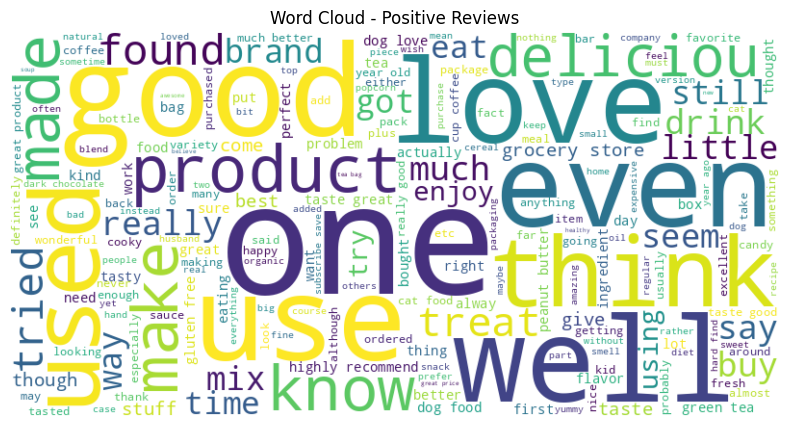

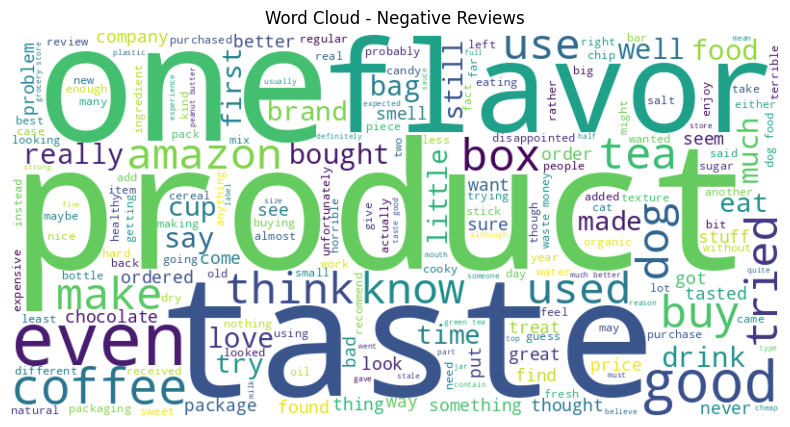

In [20]:
# WORDCLOUD FOR POSITIVE & NEGATIVE REVIEWS

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Prepare text for each sentiment
positive_text = " ".join(df[df['sentiment'] == 'Positive']['clean_text'].dropna().astype(str))
negative_text = " ".join(df[df['sentiment'] == 'Negative']['clean_text'].dropna().astype(str))

# WordCloud - Positive Reviews
positive_wc = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Positive Reviews")
plt.show()

# WordCloud - Negative Reviews
negative_wc = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Negative Reviews")
plt.show()

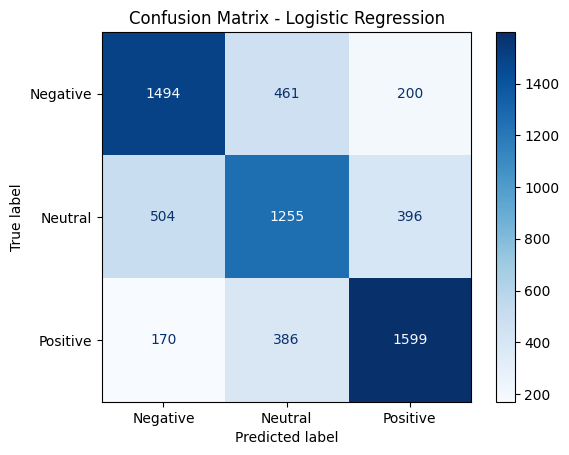

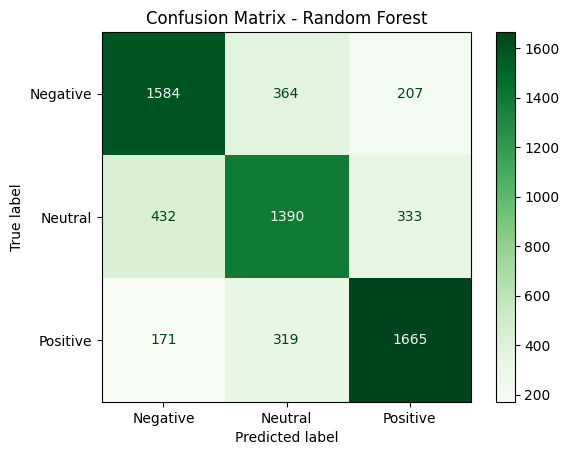

In [21]:
# CONFUSION MATRIX FOR MODEL EVALUATION

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix - Logistic Regression
cm_log = confusion_matrix(y_test, log_reg_preds, labels=['Negative', 'Neutral', 'Positive'])
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=['Negative', 'Neutral', 'Positive'])
disp_log.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test, rf_preds, labels=['Negative', 'Neutral', 'Positive'])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Negative', 'Neutral', 'Positive'])
disp_rf.plot(cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.show()
